請輸入訓練資料數量（例如 1000）：500
Epoch 1/20 | G_loss: 0.6201 | D_loss: 0.8262
Epoch 2/20 | G_loss: 0.5477 | D_loss: 0.9140
Epoch 3/20 | G_loss: 0.5590 | D_loss: 0.9257
Epoch 4/20 | G_loss: 0.6853 | D_loss: 0.8356
Epoch 5/20 | G_loss: 0.7975 | D_loss: 0.9045
Epoch 6/20 | G_loss: 0.4990 | D_loss: 1.1916
Epoch 7/20 | G_loss: 0.4647 | D_loss: 1.3798
Epoch 8/20 | G_loss: 0.5735 | D_loss: 1.1934
Epoch 9/20 | G_loss: 0.7441 | D_loss: 0.9554
Epoch 10/20 | G_loss: 0.8277 | D_loss: 0.8566
Epoch 11/20 | G_loss: 0.7642 | D_loss: 0.9139
Epoch 12/20 | G_loss: 0.6312 | D_loss: 1.1136
Epoch 13/20 | G_loss: 0.5896 | D_loss: 1.2039
Epoch 14/20 | G_loss: 0.6665 | D_loss: 1.0743
Epoch 15/20 | G_loss: 0.8356 | D_loss: 0.8875
Epoch 16/20 | G_loss: 0.9847 | D_loss: 0.8062
Epoch 17/20 | G_loss: 1.1744 | D_loss: 0.6804
Epoch 18/20 | G_loss: 1.2548 | D_loss: 0.6431
Epoch 19/20 | G_loss: 1.3582 | D_loss: 0.6084
Epoch 20/20 | G_loss: 1.3413 | D_loss: 0.6588


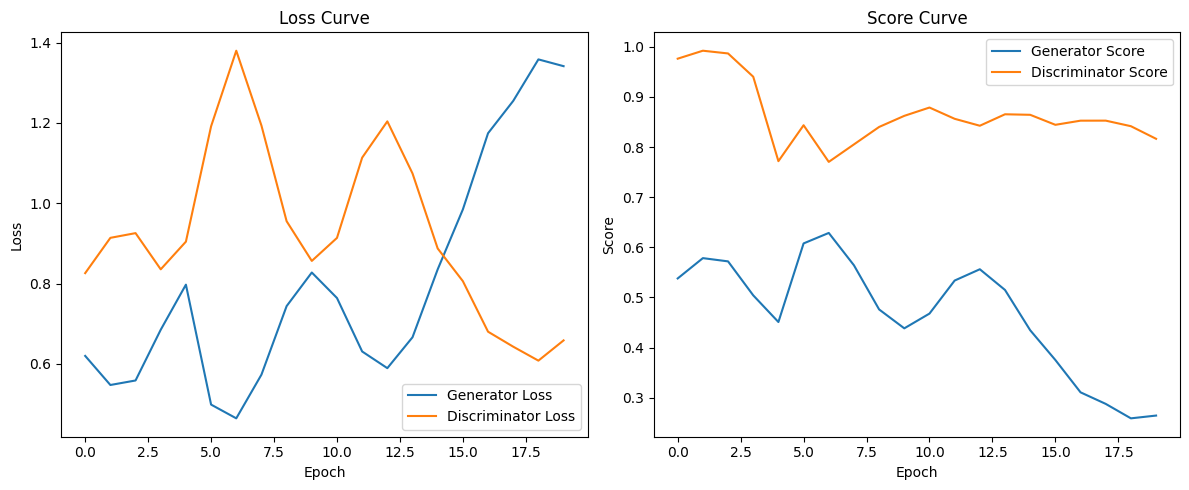

In [ ]:
# 安裝必要套件（如果尚未安裝）
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# ?? 使用者輸入：訓練資料數量
training_data_size = int(input("請輸入訓練資料數量（例如 1000）："))

# ?? 資料載入與預處理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(training_data_size))
train_loader = DataLoader(Subset(full_dataset, subset_indices), batch_size=64, shuffle=True)

# ?? 建立 Generator 與 Discriminator 模型
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# ?? 初始化模型與優化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
loss_fn = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

# ?? 儲存 loss 與 score
g_losses, d_losses = [], []
g_scores, d_scores = [], []

# ?? 訓練迴圈
epochs = 20
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # 訓練 Discriminator
        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = loss_fn(D(real_imgs), real_labels)
        d_fake_loss = loss_fn(D(fake_imgs.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # 訓練 Generator
        g_loss = loss_fn(D(fake_imgs), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # 儲存每個 epoch 的 loss 與 score
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    g_scores.append(D(fake_imgs).mean().item())
    d_scores.append(D(real_imgs).mean().item())

    print(f"Epoch {epoch+1}/{epochs} | G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}")

# ?? 繪製 Loss 與 Score 曲線
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(g_scores, label='Generator Score')
plt.plot(d_scores, label='Discriminator Score')
plt.title('Score Curve')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

Device: cuda
[Epoch 01/20] G_loss: 0.8184 | D_loss: 1.0863 | G_score≈0.436 | D_score≈0.620 | sigma=0.100
[Epoch 02/20] G_loss: 0.9706 | D_loss: 1.0221 | G_score≈0.362 | D_score≈0.624 | sigma=0.095
[Epoch 03/20] G_loss: 1.0457 | D_loss: 0.9947 | G_score≈0.332 | D_score≈0.630 | sigma=0.089
[Epoch 04/20] G_loss: 1.0266 | D_loss: 1.0286 | G_score≈0.339 | D_score≈0.617 | sigma=0.084
[Epoch 05/20] G_loss: 1.0028 | D_loss: 1.0652 | G_score≈0.349 | D_score≈0.603 | sigma=0.079
[Epoch 06/20] G_loss: 0.9915 | D_loss: 1.0869 | G_score≈0.354 | D_score≈0.596 | sigma=0.074
[Epoch 07/20] G_loss: 0.9889 | D_loss: 1.0934 | G_score≈0.356 | D_score≈0.594 | sigma=0.068
[Epoch 08/20] G_loss: 0.9722 | D_loss: 1.1171 | G_score≈0.363 | D_score≈0.586 | sigma=0.063
[Epoch 09/20] G_loss: 0.9552 | D_loss: 1.1363 | G_score≈0.370 | D_score≈0.579 | sigma=0.058
[Epoch 10/20] G_loss: 0.9504 | D_loss: 1.1433 | G_score≈0.372 | D_score≈0.576 | sigma=0.053
[Epoch 11/20] G_loss: 0.9516 | D_loss: 1.1420 | G_score≈0.372 | D_s

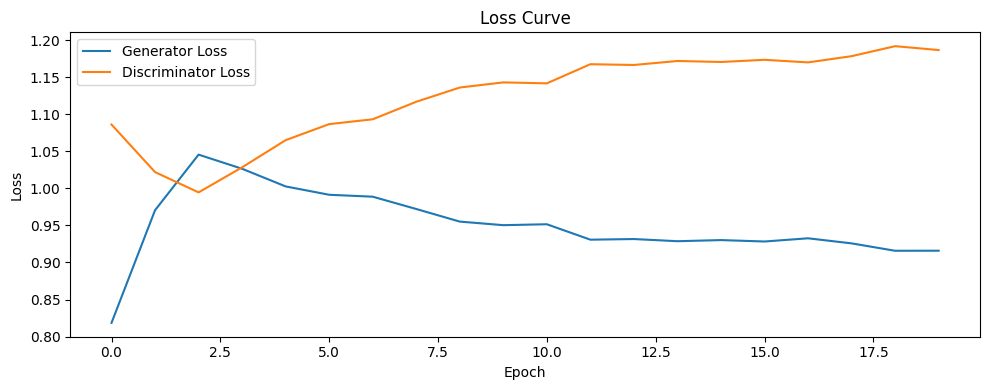

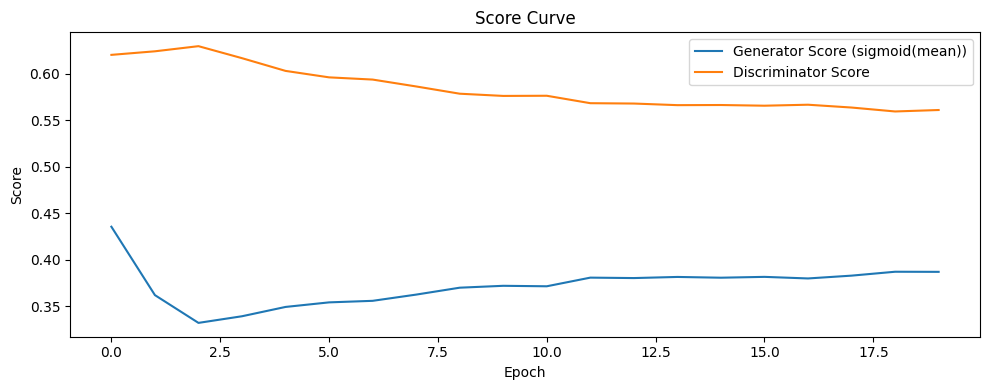

In [ ]:
# ====== GAN on MNIST：穩定版（可直接執行） ======
# 若在 Colab 第一次使用，取消下一行註解安裝套件
# !pip install -q torch torchvision matplotlib

import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

# ---------- 超參數 ----------
seed = 42
z_dim = 100
batch_size = 64
epochs = 20
g_lr = 2e-4
d_lr = 1e-4                 # 放慢 D
betas = (0.5, 0.999)
real_label_smooth = 0.9     # label smoothing
save_dir = "./gan_mnist_out"
os.makedirs(save_dir, exist_ok=True)

# ---------- 固定隨機種子 ----------
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# ---------- 裝置 ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- 資料 ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # 映射到 [-1, 1]，配合 Tanh
])
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

# ---------- 模型 ----------
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.model(z)
        return x.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # **注意**：不加 Sigmoid，配 BCEWithLogitsLoss
        self.model = nn.Sequential(
            nn.Flatten(),
            spectral_norm(nn.Linear(784, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            spectral_norm(nn.Linear(256, 1))  # logits
        )
    def forward(self, x):
        return self.model(x)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

G = Generator(z_dim).to(device).apply(weights_init)
D = Discriminator().to(device).apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(G.parameters(), lr=g_lr, betas=betas)
d_optimizer = optim.Adam(D.parameters(), lr=d_lr, betas=betas)

# ---------- 追蹤 ----------
g_losses, d_losses, g_scores, d_scores = [], [], [], []
fixed_z = torch.randn(64, z_dim, device=device)

# Instance Noise：由 0.10 緩降到 0
sigma_start, sigma_end = 0.10, 0.00
def sigma_at(epoch_idx, total_epochs):
    # epoch_idx 從 1 開始
    return sigma_start + (sigma_end - sigma_start) * (epoch_idx - 1) / (total_epochs - 1)

def add_instance_noise(x, sigma):
    return x + torch.randn_like(x) * sigma if sigma > 0 else x

# ---------- 訓練 ----------
for epoch in range(1, epochs + 1):
    G.train(); D.train()
    sig = sigma_at(epoch, epochs)

    epoch_g_loss = epoch_d_loss = 0.0
    epoch_g_score = epoch_d_score = 0.0
    n_batches = 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.size(0)
        real_targets = torch.full((bsz, 1), real_label_smooth, device=device)
        fake_targets = torch.zeros(bsz, 1, device=device)

        # ---- Train D ----
        D.zero_grad(set_to_none=True)
        with torch.no_grad():
            z = torch.randn(bsz, z_dim, device=device)
            fake_imgs = G(z)
        d_real_logits = D(add_instance_noise(real_imgs, sig))
        d_fake_logits = D(add_instance_noise(fake_imgs, sig))
        d_loss = criterion(d_real_logits, real_targets) + criterion(d_fake_logits, fake_targets)
        d_loss.backward()
        d_optimizer.step()

        # 估算 D 當前強度
        with torch.no_grad():
            d_real_p = torch.sigmoid(d_real_logits).mean().item()
            d_fake_p = torch.sigmoid(d_fake_logits).mean().item()
            d_score_batch = (d_real_p + (1.0 - d_fake_p)) / 2.0  # 越接近 1 表示 D 越強

        # ---- Train G（自適應多步：D 太強時多訓一步）----
        g_steps = 2 if d_score_batch > 0.70 else 1
        last_g_logits = None
        for _ in range(g_steps):
            G.zero_grad(set_to_none=True)
            z = torch.randn(bsz, z_dim, device=device)
            gen_imgs = G(z)
            last_g_logits = D(add_instance_noise(gen_imgs, sig))
            g_loss = criterion(last_g_logits, real_targets)
            g_loss.backward()
            g_optimizer.step()

        # --- 紀錄 ---
        with torch.no_grad():
            g_prob = torch.sigmoid(last_g_logits).mean().item()
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_g_score += g_prob
        epoch_d_score += d_score_batch
        n_batches += 1

    # 平均化
    g_losses.append(epoch_g_loss / n_batches)
    d_losses.append(epoch_d_loss / n_batches)
    g_scores.append(epoch_g_score / n_batches)
    d_scores.append(epoch_d_score / n_batches)

    # 產生固定噪聲的樣本快照
    with torch.no_grad():
        samples = G(fixed_z).cpu()
        samples = (samples + 1) / 2  # [-1,1] -> [0,1]
        save_image(samples, os.path.join(save_dir, f"samples_epoch_{epoch:03d}.png"), nrow=8)

    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"G_loss: {g_losses[-1]:.4f} | D_loss: {d_losses[-1]:.4f} | "
          f"G_score≈{g_scores[-1]:.3f} | D_score≈{d_scores[-1]:.3f} | "
          f"sigma={sig:.3f}")

print(f"✅ 影像樣本與輸出已存到：{save_dir}")

# ---------- 視覺化 ----------
plt.figure(figsize=(10,4))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(g_scores, label="Generator Score (sigmoid(mean))")
plt.plot(d_scores, label="Discriminator Score")
plt.title("Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


Device: cuda
[Epoch 01/20] G_loss: 0.7128 | D_loss: 1.3661 | G_score≈0.489 | D_score≈0.546 | sigma=0.150
[Epoch 02/20] G_loss: 0.7711 | D_loss: 1.3335 | G_score≈0.450 | D_score≈0.527 | sigma=0.143
[Epoch 03/20] G_loss: 0.7934 | D_loss: 1.3401 | G_score≈0.437 | D_score≈0.521 | sigma=0.136
[Epoch 04/20] G_loss: 0.7993 | D_loss: 1.3308 | G_score≈0.434 | D_score≈0.526 | sigma=0.129
[Epoch 05/20] G_loss: 0.8166 | D_loss: 1.3275 | G_score≈0.425 | D_score≈0.530 | sigma=0.123
[Epoch 06/20] G_loss: 0.8130 | D_loss: 1.3353 | G_score≈0.427 | D_score≈0.527 | sigma=0.116
[Epoch 07/20] G_loss: 0.8092 | D_loss: 1.3396 | G_score≈0.429 | D_score≈0.523 | sigma=0.109
[Epoch 08/20] G_loss: 0.8139 | D_loss: 1.3357 | G_score≈0.426 | D_score≈0.526 | sigma=0.102
[Epoch 09/20] G_loss: 0.8197 | D_loss: 1.3285 | G_score≈0.422 | D_score≈0.529 | sigma=0.095
[Epoch 10/20] G_loss: 0.8258 | D_loss: 1.3254 | G_score≈0.420 | D_score≈0.532 | sigma=0.088
[Epoch 11/20] G_loss: 0.8178 | D_loss: 1.3365 | G_score≈0.424 | D_s

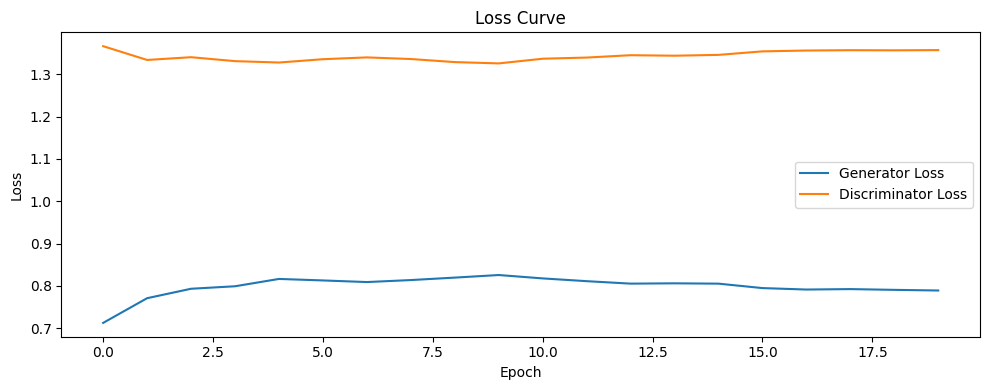

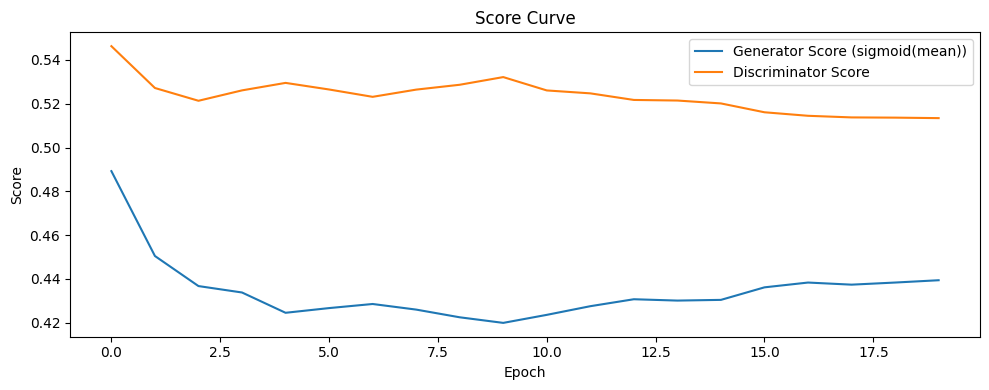

In [ ]:
# ====== GAN on MNIST：穩定 Plus 版（可直接執行） ======
# !pip install -q torch torchvision matplotlib

import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

# ---------- 超參數 ----------
seed = 42
z_dim = 100
batch_size = 64
epochs = 20
g_lr = 2e-4
d_lr = 5e-5                 # TTUR：放慢 D
betas = (0.5, 0.999)
real_label_smooth = 0.9
label_flip_p = 0.05         # 5% 小比例標籤翻轉
r1_gamma = 5.0              # R1 梯度正則強度
save_dir = "./gan_mnist_out_plus"
os.makedirs(save_dir, exist_ok=True)

# ---------- 固定 seed / 裝置 ----------
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- 資料 ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # [-1,1]，配合 Tanh
])
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

# ---------- 模型 ----------
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.model(z)
        return x.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 不加 Sigmoid，配 BCEWithLogitsLoss
        self.model = nn.Sequential(
            nn.Flatten(),
            spectral_norm(nn.Linear(784, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            spectral_norm(nn.Linear(256, 1))  # logits
        )
    def forward(self, x):
        return self.model(x)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

G = Generator(z_dim).to(device).apply(weights_init)
D = Discriminator().to(device).apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
g_opt = optim.Adam(G.parameters(), lr=g_lr, betas=betas)
d_opt = optim.Adam(D.parameters(), lr=d_lr, betas=betas)

# ---------- 追蹤 ----------
g_losses, d_losses, g_scores, d_scores = [], [], [], []
fixed_z = torch.randn(64, z_dim, device=device)

# Instance Noise：由 0.15 緩降到 0.02（更慢退火）
sigma_start, sigma_end = 0.15, 0.02
def sigma_at(epoch_idx, total_epochs):
    return sigma_start + (sigma_end - sigma_start) * (epoch_idx - 1) / (total_epochs - 1)
def add_instance_noise(x, sigma):
    return x + torch.randn_like(x) * sigma if sigma > 0 else x

# ---------- 訓練 ----------
for epoch in range(1, epochs + 1):
    G.train(); D.train()
    sig = sigma_at(epoch, epochs)

    epoch_g_loss = epoch_d_loss = 0.0
    epoch_g_score = epoch_d_score = 0.0
    n_batches = 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.size(0)

        # label smoothing + 少量翻轉
        real_targets = torch.full((bsz, 1), real_label_smooth, device=device)
        fake_targets = torch.zeros(bsz, 1, device=device)
        if label_flip_p > 0:
            real_flip = torch.rand_like(real_targets) < label_flip_p
            fake_flip = torch.rand_like(fake_targets) < label_flip_p
            real_targets = torch.where(real_flip, torch.zeros_like(real_targets), real_targets)
            fake_targets = torch.where(fake_flip, torch.ones_like(fake_targets), fake_targets)

        # ---- Train D（含 R1 正則在真樣本）----
        D.zero_grad(set_to_none=True)
        with torch.no_grad():
            z = torch.randn(bsz, z_dim, device=device)
            fake_imgs = G(z)

        # R1: 需要對 real_imgs 求梯度
        real_imgs.requires_grad_(True)
        d_real_logits = D(add_instance_noise(real_imgs, sig))
        d_fake_logits = D(add_instance_noise(fake_imgs, sig))

        d_loss_basic = criterion(d_real_logits, real_targets) + criterion(d_fake_logits, fake_targets)

        # R1 梯度懲罰（對真樣本）
        r1_grads = torch.autograd.grad(
            outputs=d_real_logits.sum(), inputs=real_imgs,
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        r1_penalty = 0.5 * r1_gamma * (r1_grads.view(bsz, -1).pow(2).sum(dim=1)).mean()

        d_loss = d_loss_basic + r1_penalty
        d_loss.backward()
        d_opt.step()
        real_imgs = real_imgs.detach()  # 清掉需要梯度

        # 估算 D 當前強度
        with torch.no_grad():
            d_real_p = torch.sigmoid(d_real_logits).mean().item()
            d_fake_p = torch.sigmoid(d_fake_logits).mean().item()
            d_score_batch = (d_real_p + (1.0 - d_fake_p)) / 2.0

        # ---- Train G（自適應多步：D 太強就多訓 2~3 次）----
        g_steps = 1 + int(d_score_batch > 0.60) + int(d_score_batch > 0.65)  # 1~3 步
        last_g_logits = None
        for _ in range(g_steps):
            G.zero_grad(set_to_none=True)
            z = torch.randn(bsz, z_dim, device=device)
            gen_imgs = G(z)
            last_g_logits = D(add_instance_noise(gen_imgs, sig))
            g_loss = criterion(last_g_logits, real_targets)  # 想被判成真
            g_loss.backward()
            g_opt.step()

        # --- 紀錄 ---
        with torch.no_grad():
            g_prob = torch.sigmoid(last_g_logits).mean().item()
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_g_score += g_prob
        epoch_d_score += d_score_batch
        n_batches += 1

    # 平均化
    g_losses.append(epoch_g_loss / n_batches)
    d_losses.append(epoch_d_loss / n_batches)
    g_scores.append(epoch_g_score / n_batches)
    d_scores.append(epoch_d_score / n_batches)

    # 固定噪聲樣本
    with torch.no_grad():
        samples = G(fixed_z).cpu()
        samples = (samples + 1) / 2
        save_image(samples, os.path.join(save_dir, f"samples_epoch_{epoch:03d}.png"), nrow=8)

    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"G_loss: {g_losses[-1]:.4f} | D_loss: {d_losses[-1]:.4f} | "
          f"G_score≈{g_scores[-1]:.3f} | D_score≈{d_scores[-1]:.3f} | "
          f"sigma={sig:.3f}")

print(f"✅ 影像樣本與輸出已存到：{save_dir}")

# ---------- 視覺化 ----------
plt.figure(figsize=(10,4))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(g_scores, label="Generator Score (sigmoid(mean))")
plt.plot(d_scores, label="Discriminator Score")
plt.title("Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


Device: cuda
[Epoch 01/25] G_loss: -0.3326 | D_loss: 1.5658 | G_score≈0.581 | D_score≈0.554
[Epoch 02/25] G_loss: -0.1658 | D_loss: 1.7462 | G_score≈0.540 | D_score≈0.530
[Epoch 03/25] G_loss: 0.0091 | D_loss: 1.7656 | G_score≈0.498 | D_score≈0.528
[Epoch 04/25] G_loss: -0.0586 | D_loss: 1.8246 | G_score≈0.514 | D_score≈0.521
[Epoch 05/25] G_loss: -0.0425 | D_loss: 1.8512 | G_score≈0.511 | D_score≈0.518
[Epoch 06/25] G_loss: -0.0402 | D_loss: 1.8698 | G_score≈0.510 | D_score≈0.516
[Epoch 07/25] G_loss: -0.0251 | D_loss: 1.8762 | G_score≈0.506 | D_score≈0.515
[Epoch 08/25] G_loss: -0.0313 | D_loss: 1.8789 | G_score≈0.508 | D_score≈0.515
[Epoch 09/25] G_loss: -0.0412 | D_loss: 1.8768 | G_score≈0.510 | D_score≈0.515
[Epoch 10/25] G_loss: -0.0086 | D_loss: 1.8761 | G_score≈0.503 | D_score≈0.515
[Epoch 11/25] G_loss: -0.0206 | D_loss: 1.8789 | G_score≈0.505 | D_score≈0.515
[Epoch 12/25] G_loss: -0.0141 | D_loss: 1.8783 | G_score≈0.504 | D_score≈0.515
[Epoch 13/25] G_loss: -0.0934 | D_loss: 

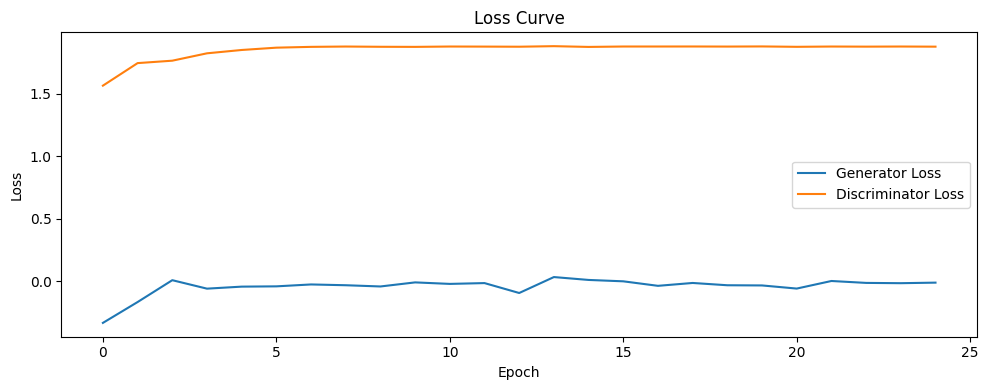

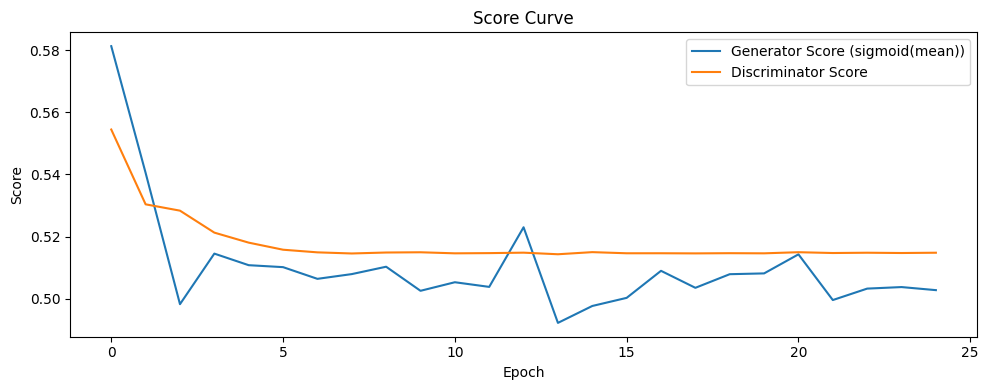

In [ ]:
# ===== DCGAN (Conv) on MNIST with Hinge Loss — 可直接執行 =====
# 若在 Colab 第一次使用，取消下一行註解安裝套件
# !pip install -q torch torchvision matplotlib

import os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

# ---------- 超參數 ----------
seed = 42
z_dim = 100
batch_size = 128
epochs = 25
g_lr = 2e-4
d_lr = 1e-4                 # TTUR：D 慢一點
betas = (0.5, 0.999)
save_dir = "./dcgan_mnist_hinge_out"
os.makedirs(save_dir, exist_ok=True)

# ---------- 固定 seed / 裝置 ----------
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- 資料 ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # 映射到 [-1,1]，配合 Tanh
])
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

# ---------- 模型 ----------
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            # 7x7x128 -> 14x14x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 14x14x64 -> 28x28x1
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 不加 Sigmoid；Hinge Loss 使用「logits」
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),   # 28->14
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)), # 14->7
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            spectral_norm(nn.Linear(128 * 7 * 7, 1))
        )

    def forward(self, x):
        return self.main(x)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

G = Generator(z_dim).to(device).apply(weights_init)
D = Discriminator().to(device).apply(weights_init)

g_opt = optim.Adam(G.parameters(), lr=g_lr, betas=betas)
d_opt = optim.Adam(D.parameters(), lr=d_lr, betas=betas)

# ---------- 追蹤 ----------
g_losses, d_losses, g_scores, d_scores = [], [], [], []
fixed_z = torch.randn(64, z_dim, device=device)

# ---------- Hinge 損失 ----------
# D:  max(0, 1 - D(real)) + max(0, 1 + D(fake))
# G:  - D(fake)
relu = nn.ReLU()

# ---------- 訓練 ----------
for epoch in range(1, epochs + 1):
    G.train(); D.train()
    ep_g, ep_d, ep_gs, ep_ds, n = 0.0, 0.0, 0.0, 0.0, 0

    for real, _ in train_loader:
        real = real.to(device)
        bsz = real.size(0)

        # ---- Train D ----
        D.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            fake = G(z)

        d_real = D(real)
        d_fake = D(fake)
        d_loss = relu(1.0 - d_real).mean() + relu(1.0 + d_fake).mean()
        d_loss.backward()
        d_opt.step()

        # ---- Train G ----
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        fake = G(z)
        g_loss = -D(fake).mean()
        g_loss.backward()
        g_opt.step()

        # ---- 指標（用 sigmoid 轉成「偽機率」便於觀察）----
        with torch.no_grad():
            d_real_p = torch.sigmoid(d_real).mean().item()
            d_fake_p = torch.sigmoid(d_fake).mean().item()
            d_score = (d_real_p + (1.0 - d_fake_p)) / 2.0
            g_prob = torch.sigmoid(D(fake)).mean().item()

        ep_g += g_loss.item(); ep_d += d_loss.item()
        ep_gs += g_prob; ep_ds += d_score; n += 1

    g_losses.append(ep_g / n); d_losses.append(ep_d / n)
    g_scores.append(ep_gs / n); d_scores.append(ep_ds / n)

    # 固定噪聲樣本
    with torch.no_grad():
        samples = G(fixed_z).cpu()
        samples = (samples + 1) / 2
        save_image(samples, os.path.join(save_dir, f"samples_epoch_{epoch:03d}.png"), nrow=8)

    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"G_loss: {g_losses[-1]:.4f} | D_loss: {d_losses[-1]:.4f} | "
          f"G_score≈{g_scores[-1]:.3f} | D_score≈{d_scores[-1]:.3f}")

print(f"✅ 影像樣本與輸出已存到：{save_dir}")

# ---------- 視覺化 ----------
plt.figure(figsize=(10,4))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(g_scores, label="Generator Score (sigmoid(mean))")
plt.plot(d_scores, label="Discriminator Score")
plt.title("Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout(); plt.show()


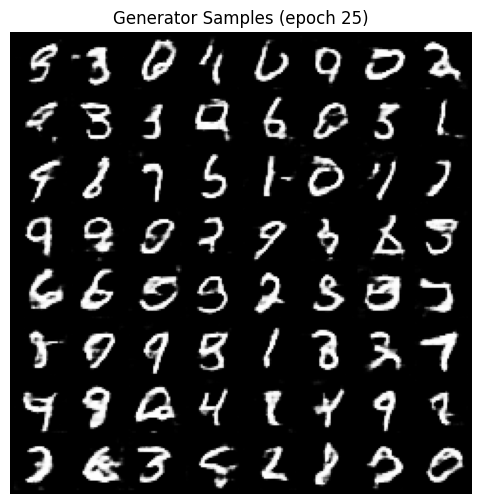

[Epoch 25/25] G_loss: 0.0177 | D_loss: 1.8820 | G_score≈0.496 | D_score≈0.514
✅ 影像樣本與輸出已存到：./dcgan_mnist_hinge_out
🎞 已輸出 GIF： ./dcgan_mnist_hinge_out/training_evolution.gif


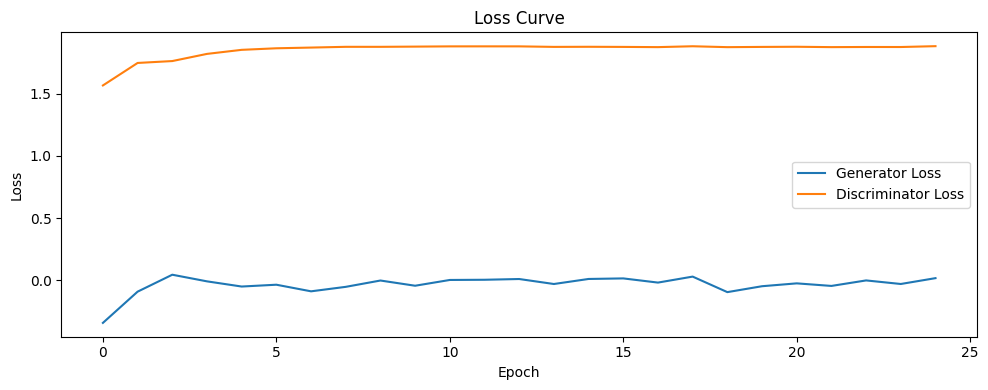

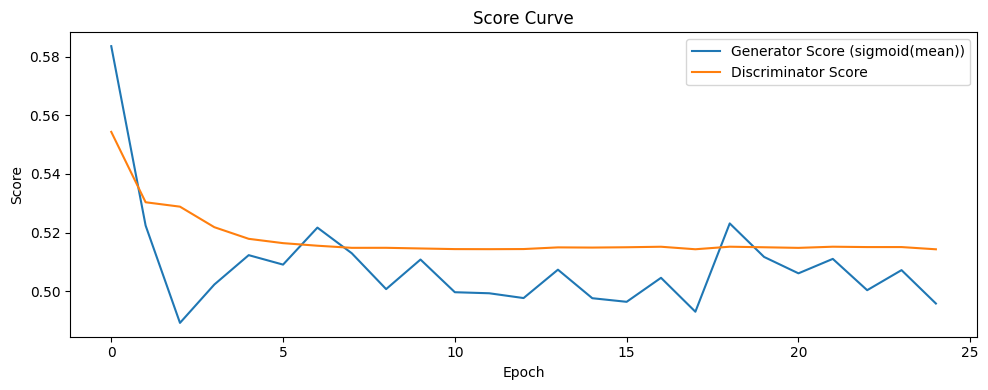

In [ ]:
# ===== DCGAN (Conv) on MNIST with Hinge Loss — 即時顯示版 =====
# !pip install -q torch torchvision matplotlib imageio

import os, random, glob, re
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
from IPython.display import clear_output, display
import imageio.v2 as imageio

# ---------- 顯示/輸出設定 ----------
LIVE_PREVIEW = True      # 每個 epoch 即時顯示生成圖
MAKE_GIF     = True      # 訓練結束把 samples 串成 GIF
GIF_FPS      = 4

# ---------- 超參數 ----------
seed = 42
z_dim = 100
batch_size = 128
epochs = 25
g_lr = 2e-4
d_lr = 1e-4                 # TTUR：D 慢一點
betas = (0.5, 0.999)
save_dir = "./dcgan_mnist_hinge_out"
os.makedirs(save_dir, exist_ok=True)

# ---------- 固定 seed / 裝置 ----------
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- 資料 ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # 映射到 [-1,1]，配合 Tanh
])
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

# ---------- 模型 ----------
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            # 7x7x128 -> 14x14x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 14x14x64 -> 28x28x1
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 不加 Sigmoid；Hinge Loss 使用 logits
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),   # 28->14
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)), # 14->7
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            spectral_norm(nn.Linear(128 * 7 * 7, 1))
        )

    def forward(self, x):
        return self.main(x)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_((m.weight), 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

G = Generator(z_dim).to(device).apply(weights_init)
D = Discriminator().to(device).apply(weights_init)

g_opt = optim.Adam(G.parameters(), lr=g_lr, betas=betas)
d_opt = optim.Adam(D.parameters(), lr=d_lr, betas=betas)

# ---------- 追蹤 ----------
g_losses, d_losses, g_scores, d_scores = [], [], [], []
fixed_z = torch.randn(64, z_dim, device=device)

# ---------- Hinge 損失 ----------
relu = nn.ReLU()

def preview(samples, title):
    """把 64 張 28x28 圖拼成一張並即時顯示"""
    grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    clear_output(wait=True)
    plt.figure(figsize=(6,6))
    plt.imshow(npimg.squeeze(), cmap='gray')
    plt.axis("off")
    plt.title(title)
    display(plt.gcf())
    plt.close()

# ---------- 訓練 ----------
for epoch in range(1, epochs + 1):
    G.train(); D.train()
    ep_g, ep_d, ep_gs, ep_ds, n = 0.0, 0.0, 0.0, 0.0, 0

    for real, _ in train_loader:
        real = real.to(device)
        bsz = real.size(0)

        # ---- Train D ----
        D.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            fake = G(z)

        d_real = D(real)
        d_fake = D(fake)
        d_loss = relu(1.0 - d_real).mean() + relu(1.0 + d_fake).mean()
        d_loss.backward()
        d_opt.step()

        # ---- Train G ----
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        fake = G(z)
        g_loss = -D(fake).mean()
        g_loss.backward()
        g_opt.step()

        # ---- 指標（用 sigmoid 轉「偽機率」觀察）----
        with torch.no_grad():
            d_real_p = torch.sigmoid(d_real).mean().item()
            d_fake_p = torch.sigmoid(d_fake).mean().item()
            d_score = (d_real_p + (1.0 - d_fake_p)) / 2.0
            g_prob = torch.sigmoid(D(fake)).mean().item()

        ep_g += g_loss.item(); ep_d += d_loss.item()
        ep_gs += g_prob; ep_ds += d_score; n += 1

    g_losses.append(ep_g / n); d_losses.append(ep_d / n)
    g_scores.append(ep_gs / n); d_scores.append(ep_ds / n)

    # 固定噪聲樣本 + 儲存 +（可選）即時預覽
    with torch.no_grad():
        samples = G(fixed_z).cpu()
        save_path = os.path.join(save_dir, f"samples_epoch_{epoch:03d}.png")
        # [-1,1] -> [0,1] 存檔
        save_image((samples + 1) / 2, save_path, nrow=8)
        if LIVE_PREVIEW:
            preview(samples, f"Generator Samples (epoch {epoch})")

    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"G_loss: {g_losses[-1]:.4f} | D_loss: {d_losses[-1]:.4f} | "
          f"G_score≈{g_scores[-1]:.3f} | D_score≈{d_scores[-1]:.3f}")

print(f"✅ 影像樣本與輸出已存到：{save_dir}")

# ----------（可選）把所有 epoch 的 samples 串成 GIF ----------
if MAKE_GIF:
    frames = []
    files = sorted(glob.glob(os.path.join(save_dir, "samples_epoch_*.png")),
                   key=lambda f: int(re.search(r"(\d+)", os.path.basename(f)).group(1)))
    for f in files:
        frames.append(imageio.imread(f))
    gif_path = os.path.join(save_dir, "training_evolution.gif")
    if frames:
        imageio.mimsave(gif_path, frames, fps=GIF_FPS)
        print("🎞 已輸出 GIF：", gif_path)

# ---------- 視覺化 Loss/Score 曲線 ----------
plt.figure(figsize=(10,4))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(g_scores, label="Generator Score (sigmoid(mean))")
plt.plot(d_scores, label="Discriminator Score")
plt.title("Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout(); plt.show()

# ---------- 額外：即時抽樣函式（需要時呼叫） ----------
def show_from_G(G, z_dim=100, n=64, nrow=8, title="Generator samples (live)"):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, z_dim, device=next(G.parameters()).device)
        fake = G(z).detach().cpu()
        grid = make_grid(fake, nrow=nrow, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off"); plt.title(title); plt.show()

# 用法：
# show_from_G(G, z_dim=100)  # 任意時刻即時顯示生成器的圖
